<a href="https://colab.research.google.com/github/markiyan-konyk/UTMIST-Rehab/blob/main/UTMIST_Neuro_Rehab_Dev_Onboarding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTMIST X NeuroTech UofT
## Post Stroke Neurorehab Project
### Software Team Onboarding

By - Zakariyya Brewster, Divy Wadhwani

Hello everyone. Welcome to the NeuroRehab project! We are excited to have you on board. This notebook is your guided tour and sandbox:

- What we are building: intent recognition from sEMG-like signals for post-stroke neurorehab.
- What you will do here: verify your environment, explore NumPy/Pandas/sklearn, and train simple PyTorch baselines (CNN, LSTM, GNNs).
- How to use this: run cells in order, read the notes, and leave TODO comments as you discover improvements.

If you are new to a topic, skim the math notes first, then run the code cells.

In [ ]:
#Make sure to set runtime to use T4 GPU from colab
import random, numpy as np, torch
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

print("Welcome to NeuroRehab! Seed set to 42.")
print("CUDA available:", torch.cuda.is_available())

Welcome to NeuroRehab! Seed set to 42.
CUDA available: True


## Expectations & Workflow

- Write readable, commented code. Small functions > large monoliths.
- Prefer notebooks for exploration and Python modules for reusable code.
- Keep experiments reproducible: fix seeds, record hyperparameters, and log metrics.
- Use clear commit messages and small pull requests.

**Task:** After you finish this notebook, push a short summary in `notes/onboarding/<yourname>.md`:
- Environment used (Python/PyTorch versions)
- Any issues you hit + fixes
- One idea to improve our baseline

In [ ]:
# Helper: simple experiment config holder you can reuse
from dataclasses import dataclass, asdict

@dataclass
class ExperimentConfig:
    seed: int = 42
    n_samples: int = 1500
    n_channels: int = 8
    timesteps: int = 256
    n_classes: int = 5
    test_size: float = 0.2
    batch_size: int = 64
    epochs: int = 8
    lr: float = 1e-3
    model: str = "cnn"  # or "lstm"

cfg = ExperimentConfig()
asdict(cfg)

{'seed': 42,
 'n_samples': 1500,
 'n_channels': 8,
 'timesteps': 256,
 'n_classes': 5,
 'test_size': 0.2,
 'batch_size': 64,
 'epochs': 8,
 'lr': 0.001,
 'model': 'cnn'}

## Environment Check & Imports

We keep the stack minimal:
- NumPy, Pandas, Matplotlib
- scikit-learn for baselines
- PyTorch for DL (CNN, LSTM, GNN)

If imports fail, install locally or in your virtual environment.

In [1]:
import os, sys, math, time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)

import sklearn
print("scikit-learn:", sklearn.__version__)
print("PyTorch:", torch.__version__)


Python: 3.12.11
NumPy: 2.0.2
Pandas: 2.2.2
scikit-learn: 1.6.1
PyTorch: 2.8.0+cu126


## Data Processing + classic ML

We'll be using the following libraries in our project for processing our data and making sample ML baselines.

- **NumPy** → numerical computing, linear algebra, vectorized ops  
- **Pandas** → tabular data wrangling & metadata  
- **Matplotlib** → plotting & visualization  
- **scikit-learn** → classical ML, preprocessing, pipelines  


Later sections will cover **deep learning models** (CNN, LSTM, GNN) with PyTorch.

Run the cells in order, read the explanations, and experiment with the examples!

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

## NumPy Basics

NumPy is our numerical backbone. It gives us fast arrays and linear algebra.

Key operations you’ll use often:
- Array creation (`np.array`, `np.linspace`, `np.zeros`, etc.)
- Broadcasting (`(N,1)` + `(1,D)` without loops)
- Vectorized math (`np.mean`, `np.dot`, `np.linalg.norm`)


In [ ]:
# Create arrays
a = np.array([1, 2, 3])
b = np.linspace(0, 1, 5)

print("a:", a)
print("b:", b)

# Broadcasting example: outer sum
outer = a[:, None] + b[None, :]
print("\nBroadcasted outer sum:\n", outer)

# Linear algebra: dot product & norm
v = np.array([3, 4])
print("\nDot product v·v:", np.dot(v, v))
print("L2 norm of v:", np.linalg.norm(v))


a: [1 2 3]
b: [0.   0.25 0.5  0.75 1.  ]

Broadcasted outer sum:
 [[1.   1.25 1.5  1.75 2.  ]
 [2.   2.25 2.5  2.75 3.  ]
 [3.   3.25 3.5  3.75 4.  ]]

Dot product v·v: 25
L2 norm of v: 5.0


## Pandas Basics

Pandas is great for **tabular data** and **metadata tracking**.

Core tools:
- `DataFrame` and `Series`
- `.head()`, `.info()`, `.describe()` for inspection
- Column selection, filtering, groupby

In [ ]:
data = {
    "subject": ["A", "B", "C", "D"],
    "age": [29, 35, 42, 23],
    "signal_rms": [0.9, 1.2, 0.7, 1.0]
}
df = pd.DataFrame(data)

print("DataFrame preview:")
display(df)

# Summary stats
print("\nSummary statistics:")
display(df.describe())

# Filtering
print("\nFilter age > 30:")
display(df[df["age"] > 30])

DataFrame preview:


,subject,age,signal_rms
0,A,29,0.9
1,B,35,1.2
2,C,42,0.7
3,D,23,1.0



Summary statistics:


,age,signal_rms
count,4.00000,4.000000
mean,32.25000,0.950000
std,8.13941,0.208167
min,23.00000,0.700000
25%,27.50000,0.850000
50%,32.00000,0.950000
75%,36.75000,1.050000
max,42.00000,1.200000



Filter age > 30:


,subject,age,signal_rms
1,B,35,1.2
2,C,42,0.7


## Matplotlib Basics

We use Matplotlib for plotting.  
Common plots:
- Line plot (time series, signals)
- Histogram (distribution)
- Scatter plot (2D relationships)

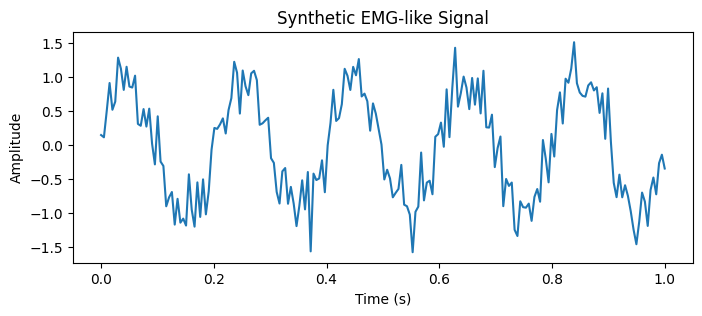

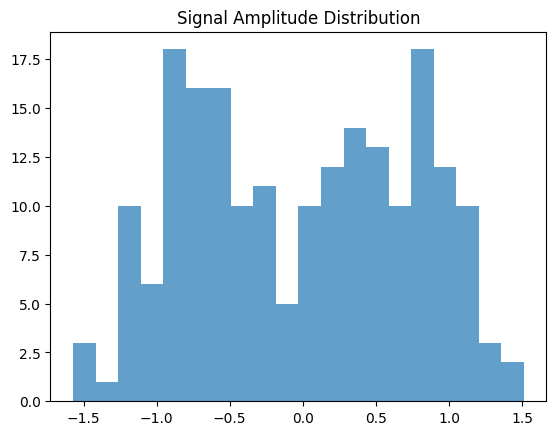

In [ ]:
t = np.linspace(0, 1, 200)
signal = np.sin(2*np.pi*5*t) + 0.3*np.random.randn(200)

plt.figure(figsize=(8, 3))
plt.plot(t, signal)
plt.title("Synthetic EMG-like Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Histogram
plt.hist(signal, bins=20, alpha=0.7)
plt.title("Signal Amplitude Distribution")
plt.show()

## scikit-learn Basics

scikit-learn is our go-to for **classical ML**:
- Train/test split
- Preprocessing (scaling, normalization)
- Models (LogisticRegression, SVM, RandomForest, etc.)
- Metrics & evaluation

In [8]:
# Synthetic dataset
X = np.random.randn(200, 3)
y = (X[:, 0] + X[:, 1]*0.5 > 0).astype(int)  # binary labels

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Pipeline: scaler + logistic regression
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])

pipe.fit(X_train, y_train)
acc = pipe.score(X_test, y_test)

print(f"Test Accuracy: {acc:.3f}")

Test Accuracy: 1.000


## Deep Learning with PyTorch

Now we move into **PyTorch**, our main deep learning framework.

Key concepts:
- `torch.Tensor` → multidimensional arrays (like NumPy, but GPU-ready)
- `nn.Module` → building blocks for neural networks
- `DataLoader` → batch iteration
- `optim` → optimization algorithms (SGD, Adam, etc.)
- Autograd → automatic differentiation

In the code cells below, you’ll fill in basic PyTorch examples.

### torch.Tensor

Tensors are the core building block of PyTorch. They are similar to NumPy arrays but come with extra powers:

* Generalized arrays: Scalars (0D), vectors (1D), matrices (2D), and higher-dimensional arrays (nD).

* GPU acceleration: Unlike NumPy, tensors can run on GPUs for massive speedups in deep learning.

* Integration with Autograd: Tensors can track computations and gradients, making them essential for training neural networks.

* Flexible operations: PyTorch provides rich APIs for math, reshaping, broadcasting, and linear algebra.

Below are some examples of the relevant creation, operation, transformation, and manipulation operations you will likely need. Feel free to look at the torch.tensor documentation: [Introduction to PyTorch Tensors](https://docs.pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html) and play around with the code below.

In [ ]:
import torchIntto
import numpy as np

# 1. Tensor Creation

# From Python list
a = torch.tensor([[1, 2], [3, 4]])
print("Tensor from list:\n", a)

# From NumPy array
b = torch.from_numpy(np.array([[5, 6], [7, 8]]))
print("\nTensor from NumPy:\n", b)

# Random / special tensors
x_rand = torch.rand(2, 3)       # Uniform [0,1)
x_zeros = torch.zeros(2, 3)
x_ones = torch.ones(2, 3)
x_eye = torch.eye(3)            # Identity matrix
x_arange = torch.arange(0, 10, 2) # Like np.arange
x_linspace = torch.linspace(0, 1, steps=5)

print("\nRandom tensor:\n", x_rand)
print("\nIdentity matrix:\n", x_eye)
print("\nArange tensor:\n", x_arange)
print("\nLinspace tensor:\n", x_linspace)


# 2. Tensor Properties

print("\nShape:", a.shape)
print("Data type:", a.dtype)
print("Device:", a.device)  # CPU or GPU


# 3. Indexing & Slicing
# ----------------------------
print("\nFirst row:", a[0])
print("First column:", a[:, 0])
print("Element [1,1]:", a[1, 1])

# Modification
a[0, 1] = 99
print("\nModified tensor:\n", a)

# Boolean indexing
mask = a > 2
print("\nBoolean mask:\n", mask)
print("Values > 2:\n", a[mask])


# 4. Tensor Math
# ----------------------------
x = torch.tensor([1.0, 2.0, 3.0])
y = torch.tensor([9.0, 8.0, 7.0])

print("\nAddition:", x + y)
print("Subtraction:", x - y)
print("Elementwise multiply:", x * y)
print("Dot product:", torch.dot(x, y))
print("Matrix multiply:", torch.mm(torch.eye(3), torch.ones(3, 3)))

# Broadcasting
z = torch.ones(3, 1)
print("\nBroadcasting example:\n", x.unsqueeze(1) + z)


# 5. Reshaping
# ----------------------------
t = torch.arange(0, 12)
print("\nOriginal:", t)

reshaped = t.reshape(3, 4)
print("\nReshaped (3x4):\n", reshaped)

transposed = reshaped.T
print("\nTransposed:\n", transposed)

flattened = reshaped.view(-1)
print("\nFlattened:\n", flattened)


# 6. Stacking & Concatenation
# ----------------------------
x1 = torch.ones(2, 3)
x2 = torch.zeros(2, 3)

print("\nConcatenated along dim 0:\n", torch.cat([x1, x2], dim=0))
print("Stacked along new dim:\n", torch.stack([x1, x2], dim=0))

# ----------------------------
# 7. Moving to GPU (if available)
# ----------------------------
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_tensor = torch.ones(2, 2).to(device)
    print("\nTensor on GPU:\n", gpu_tensor)
else:
    print("\nCUDA not available — using CPU only.")

# ----------------------------
# 8. Autograd (Automatic Differentiation)
# ----------------------------
w = torch.tensor([2.0], requires_grad=True)
x = torch.tensor([3.0])
y = w * x

# Backpropagate
y.backward()
print("\nGradient dy/dw:", w.grad)  # Should be 3

# ----------------------------
# 9. Common Reductions
# ----------------------------
m = torch.tensor([[1., 2.], [3., 4.]])
print("\nSum:", torch.sum(m))
print("Mean:", torch.mean(m))
print("Max:", torch.max(m))
print("Argmax:", torch.argmax(m))

# ----------------------------
# 10. Saving & Loading Tensors
# ----------------------------
torch.save(m, "tensor.pt")
loaded = torch.load("tensor.pt")
print("\nLoaded tensor:\n", loaded)


Tensor from list:
 tensor([[1, 2],
        [3, 4]])

Tensor from NumPy:
 tensor([[5, 6],
        [7, 8]])

Random tensor:
 tensor([[0.4807, 0.3468, 0.9924],
        [0.1098, 0.1188, 0.9744]])

Identity matrix:
 tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

Arange tensor:
 tensor([0, 2, 4, 6, 8])

Linspace tensor:
 tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])

Shape: torch.Size([2, 2])
Data type: torch.int64
Device: cpu

First row: tensor([1, 2])
First column: tensor([1, 3])
Element [1,1]: tensor(4)

Modified tensor:
 tensor([[ 1, 99],
        [ 3,  4]])

Boolean mask:
 tensor([[False,  True],
        [ True,  True]])
Values > 2:
 tensor([99,  3,  4])

Addition: tensor([10., 10., 10.])
Subtraction: tensor([-8., -6., -4.])
Elementwise multiply: tensor([ 9., 16., 21.])
Dot product: tensor(46.)
Matrix multiply: tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

Broadcasting example:
 tensor([[2.],
        [3.],
        [4.]])

Original: tensor([ 0

### Autograd

Autograd keeps track of operations on tensors and automatically computes gradients for you. This is the key feature that powers backpropagation in neural networks.

If a tensor has ```requires_grad=True```, every operation on it is recorded in a computational graph.

Calling ```.backward()``` on a result tensor (usually the loss) will traverse this graph in reverse and compute all necessary gradients.

These gradients are stored in the ```.grad``` attribute of each tensor, and can then be used by optimizers to update parameters.

**No need to manually derive derivatives!**

In [24]:
import torch

# Training data: y = 2x + 1
x = torch.tensor([[1.0], [2.0], [3.0]], requires_grad=False)
y = torch.tensor([[3.0], [5.0], [7.0]], requires_grad=False)

# Parameters (weights + bias) with gradients enabled --> want to learn true values through DL
w = torch.randn(1, requires_grad=True)  # slope
b = torch.randn(1, requires_grad=True)  # intercept

# Learning rate --> rate of update: smaller = slower, more accurate; larger = faster, less accurate
# ~ step size
lr = 0.1

for epoch in range(10):
    # ---- Forward pass ----
    y_pred = w * x + b
    loss = torch.mean((y_pred - y) ** 2)  # MSE loss

    # ---- Backward pass ----
    loss.backward()   # compute dloss/dw and dloss/db

    # ---- Update parameters (manual SGD) ----
    with torch.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad

    # ---- Zero gradients for next step ----
    # params updated by each sample fairly
    w.grad.zero_()
    b.grad.zero_()

    print(f"Epoch {epoch+1}: loss={loss.item():.4f}, w={w.item():.4f}, b={b.item():.4f}")


Epoch 1: loss=29.3157, w=2.4026, b=0.7085
Epoch 2: loss=0.3720, w=2.1434, b=0.6058
Epoch 3: loss=0.0252, w=2.1672, b=0.6273
Epoch 4: loss=0.0201, w=2.1602, b=0.6349
Epoch 5: loss=0.0191, w=2.1567, b=0.6438
Epoch 6: loss=0.0182, w=2.1529, b=0.6524
Epoch 7: loss=0.0173, w=2.1492, b=0.6607
Epoch 8: loss=0.0165, w=2.1457, b=0.6689
Epoch 9: loss=0.0157, w=2.1422, b=0.6769
Epoch 10: loss=0.0150, w=2.1387, b=0.6846


### torch.nn.Module
In PyTorch, every neural network is built as a subclass of torch.nn.Module.
Think of it as a blueprint for your model:

* Layers: Defined inside the __init__ method (e.g., Linear, Conv2d).

* Forward pass: Defined in the forward() method: describes how input tensors flow through layers.

* Parameters: Automatically registered (weights, biases) and tracked by Autograd.

* Reusable: You can easily stack, reuse, and combine modules to build complex architectures.

**```nn.Module``` makes it easy to structure models, manage parameters, and leverage PyTorch’s optimizers without manually handling tensors everywhere.**

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a simple 2-layer neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # super().__init__() ensures model behaves like a proper nn.Module
        self.fc1 = nn.Linear(4, 8)   # Input: 4 features → Hidden: 8 units
        self.fc2 = nn.Linear(8, 3)   # Hidden: 8 → Output: 3 classes

    def forward(self, x):            # input to output --> forward pass
        x = F.relu(self.fc1(x))      # Apply ReLU after first layer
        x = self.fc2(x)              # Output layer (no activation yet)
        return x

# Instantiate the model
model = SimpleNN()

# Dummy input: batch of 2 samples, each with 4 features
x = torch.rand(2, 4)

# Forward pass
output = model(x)

print("Input:", x)
print("Output:", output)


Input: tensor([[0.6945, 0.2159, 0.5746, 0.6365],
        [0.9384, 0.7685, 0.4170, 0.4274]])
Output: tensor([[ 0.1678, -0.3562,  0.1584],
        [ 0.1247, -0.4188,  0.1646]], grad_fn=<AddmmBackward0>)


In [ ]:
# Nice-to-Knows

x_lin = torch.rand(2, 4)              # batch of 2, 4 features
x_img = torch.rand(1, 3, 8, 8)        # batch of 1, 3-channel 8x8 image
x_seq = torch.rand(5, 2, 6)           # seq_len=5, batch=2, feature_size=6
x_idx = torch.randint(0, 20, (2, 3))  # batch of 2, seq length 3 (word indices)

# Linear Layer
linear = nn.Linear(4, 2)
out_lin = linear(x_lin)
print("Linear:", out_lin.shape)

# Convolutional Layer (2D for image, 3D for video, 1D for time-series)
conv = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1)
out_conv = conv(x_img)
print("Conv2d:", out_conv.shape)

# Recurrent Layer (LSTM) -> good for time-series w/ long-term dependencies

lstm = nn.LSTM(input_size=6, hidden_size=4, num_layers=1)
out_seq, (h, c) = lstm(x_seq)
print("LSTM output:", out_seq.shape)

# 4. Normalization Layer (BatchNorm2d)
# normalizes activations across batch -> N(0, 1), then scales wit learnable params
# stabilizes training, improves generalization -> less need for layer adaptation
bn = nn.BatchNorm2d(num_features=4)
out_bn = bn(out_conv)
print("BatchNorm2d:", out_bn.shape)  # (1, 4, 8, 8)

# Activation Functions -> introduce nonlinearities between layers
relu = nn.ReLU() # x if x > 0, 0 if x < 0
sigmoid = nn.Sigmoid() # 1 / 1+exp(-x), output in (0, 1)
tanh = nn.Tanh() # output in (-1, 1)
softmax = nn.Softmax(dim=1) # exp(z_i) / sum(exp(z_j))

# Pooling --> reduce spatial size of feature maps, focus on important features
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
out_maxpool = maxpool(out_conv)
avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
out_avgpool = avgpool(out_conv)
print("MaxPool2d:", out_maxpool.shape)  # (1, 4, 4, 4)
print("AvgPool2d:", out_avgpool.shape)  # (1, 4, 4, 4)

# Utility Layers

# Stack layers
seq_model = nn.Sequential(
    nn.Linear(4, 3),
    nn.ReLU(),
    nn.Linear(3, 2),
    nn.Softmax(dim=1)
)

out_seq_model = seq_model(x_lin)
print("Sequential:", out_seq_model.shape)  # (2, 2)

Linear: torch.Size([2, 2])
Conv2d: torch.Size([1, 4, 8, 8])
LSTM output: torch.Size([5, 2, 4])
BatchNorm2d: torch.Size([1, 4, 8, 8])
MaxPool2d: torch.Size([1, 4, 4, 4])
AvgPool2d: torch.Size([1, 4, 4, 4])
Sequential: torch.Size([2, 2])


### DataLoader

In PyTorch, the ```Dataset``` defines what your data looks like and how to access a single sample (like features + label).

The ```DataLoader``` then wraps that dataset and handles:

* Batching → groups samples into mini-batches.

* Shuffling → randomizes order each epoch for better training.

* Parallel loading → uses multiple workers to speed up loading.

**Dataset and DataLoader create an efficient pipeline that feeds data into your model during training.**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Define a simple dataset (y = 2x)
class MyDataset(Dataset):
    def __init__(self):
        self.data = torch.arange(10).float().unsqueeze(1)   # shape (10,1)
        self.labels = self.data * 2                         # shape (10,1)

    def __len__(self):
        return len(self.data)   # total number of samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create dataset
dataset = MyDataset()

# Wrap it in a DataLoader (batch size = 3)
loader = DataLoader(dataset, batch_size=3, shuffle=True)

# Iterate through batches
for batch_idx, (x, y) in enumerate(loader):
    print(f"Batch {batch_idx+1}")
    print("  x:", x)
    print("  y:", y)

Batch 1
  x: tensor([[9.],
        [7.],
        [6.]])
  y: tensor([[18.],
        [14.],
        [12.]])
Batch 2
  x: tensor([[4.],
        [1.],
        [8.]])
  y: tensor([[ 8.],
        [ 2.],
        [16.]])
Batch 3
  x: tensor([[5.],
        [0.],
        [2.]])
  y: tensor([[10.],
        [ 0.],
        [ 4.]])
Batch 4
  x: tensor([[3.]])
  y: tensor([[6.]])


### torch.optim

The torch.optim package contains standard optimization algorithms (like SGD, Adam, RMSprop) that update your model’s parameters using the gradients computed by Autograd.

* Optimizers take model.parameters() as input, so they know which tensors to update.

* The standard training cycle is:
  * Forward pass → compute predictions.
  * Loss → measure error.
  * Backward pass → compute gradients (```loss.backward()```).
  * Optimizer step → update parameters (```optimizer.step()```).
  * Zero gradients → reset for next iteration (```optimizer.zero_grad()```).

  **Optimizers automate weight updates so you don’t need to manually adjust parameters with gradients.**

In [ ]:
import torch
import torch.nn as nn

# Simple model
model = nn.Linear(2, 1)

# Loss function
criterion = nn.MSELoss()

# Optimizer: SGD with learning rate 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Dummy data
x = torch.tensor([[1.0, 2.0]])
y = torch.tensor([[5.0]])

# Training step
for epoch in range(3):
    # Forward pass
    pred = model(x)
    loss = criterion(pred, y)

    # Backward pass / Backprop
    optimizer.zero_grad()   # clear old gradients
    loss.backward()         # compute new gradients
    optimizer.step()        # update weights

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Other optimizers

ADAM = torch.optim.Adam(model.parameters(), lr=0.01) # standard for most ML applications
SGD_momentum = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
RMSProp = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)


Epoch 1, Loss: 18.6158
Epoch 2, Loss: 0.7446
Epoch 3, Loss: 0.0298


## Neural Networks

A Neural Network is a system of connected "neurons".  
Each neuron takes input, applies weights and biases, passes it through an activation function, and produces output.  
When many neurons are stacked together, they form layers that can approximate complex functions.

---

## 1. The Neuron

A single neuron takes inputs $x_1, x_2, \dots, x_n$ with weights $w_1, w_2, \dots, w_n$ and bias $b$:

$$
z = \sum_{i=1}^{n} w_i x_i + b
$$

Then it applies an activation function $\phi$:

$$
a = \phi(z)
$$

- $w_i$: weight  
- $b$: bias  
- $z$: weighted sum  
- $a$: activated output  

---

## 2. Activation Functions

Activation functions introduce nonlinearity.

- Sigmoid: $\sigma(z) = \frac{1}{1 + e^{-z}}$  
- Tanh: $\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$  
- ReLU: $\text{ReLU}(z) = \max(0, z)$  

Without nonlinear activations, a neural network reduces to a linear model.

---

## 3. Layers and Networks

- Input layer: receives raw features  
- Hidden layers: transform the input through neurons and activations  
- Output layer: produces predictions  

A two-layer feedforward network looks like:


\begin{aligned}
z^{(1)} &= W^{(1)} x + b^{(1)} \\
a^{(1)} &= \phi(z^{(1)}) \\
z^{(2)} &= W^{(2)} a^{(1)} + b^{(2)} \\
a^{(2)} &= \phi(z^{(2)})
\end{aligned}


---

## 4. Loss Functions

The loss function measures error between predictions and true labels.

- Mean Squared Error (MSE):

$$
L = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$

- Cross-Entropy (classification):

$$
L = - \sum_{i=1}^{N} \sum_{k=1}^{K} y_{i,k} \log \hat{y}_{i,k}
$$

where $y_{i,k}$ is 1 if sample $i$ belongs to class $k$, otherwise 0.

---

## 5. Backpropagation

Backpropagation computes gradients of the loss with respect to weights.  
It applies the chain rule layer by layer.

Example for one layer:

$
\frac{\partial L}{\partial W} = \frac{\partial L}{\partial a} \cdot \frac{\partial a}{\partial z} \cdot \frac{\partial z}{\partial W}
$

- $\frac{\partial L}{\partial a}$: effect of output on loss  
- $\frac{\partial a}{\partial z}$: derivative of activation function  
- $\frac{\partial z}{\partial W}$: effect of weights on weighted sum  

---

## 6. Gradient Descent

Weights are updated using gradients:

$$
W \leftarrow W - \eta \frac{\partial L}{\partial W}
$$

- $\eta$: learning rate  

This repeats for many epochs until the loss is minimized.

---

## 7. Training Loop Summary

1. Forward pass: compute outputs and loss  
2. Backward pass: compute gradients  
3. Update weights with gradient descent  
4. Repeat until convergence  

---

## 8. Strengths and Weaknesses

Strengths: flexible, can approximate almost any function, widely used in vision, language, and speech.  
Weaknesses: require large datasets, may overfit, training can be slow without optimization.


Device: cuda
MLP(
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
)
Trainable parameters: 11141
Epoch 01 | Loss: 1.2332 | Accuracy: 0.5333
Epoch 02 | Loss: 0.5836 | Accuracy: 0.8337
Epoch 03 | Loss: 0.4413 | Accuracy: 0.8825
Epoch 04 | Loss: 0.3901 | Accuracy: 0.8962
Epoch 05 | Loss: 0.3458 | Accuracy: 0.9094
Epoch 06 | Loss: 0.3217 | Accuracy: 0.9140
Epoch 07 | Loss: 0.3065 | Accuracy: 0.9208
Epoch 08 | Loss: 0.2918 | Accuracy: 0.9235
Epoch 09 | Loss: 0.2762 | Accuracy: 0.9292
Epoch 10 | Loss: 0.2750 | Accuracy: 0.9283
Epoch 11 | Loss: 0.2499 | Accuracy: 0.9375
Epoch 12 | Loss: 0.2497 | Accuracy: 0.9383
Epoch 13 | Loss: 0.2453 | Accura

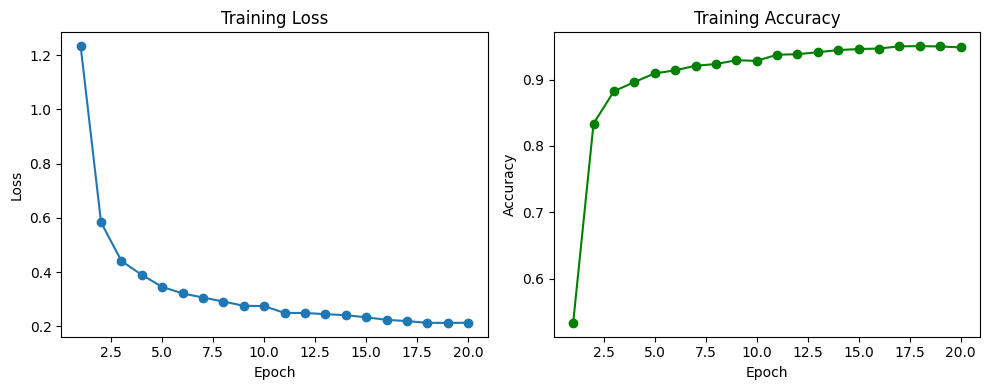

In [ ]:
# Neural Network in PyTorch: end-to-end example
# - Generates a toy classification dataset
# - Builds a 2-hidden-layer MLP
# - Trains with cross-entropy
# - Evaluates on a held-out test set and plots loss curve

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Reproducibility
def set_seed(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# 1) Data
# Synthetic multi-class classification with moderate feature count
X, y = make_classification(
    n_samples=6000,
    n_features=16,
    n_informative=10,
    n_redundant=2,
    n_repeated=0,
    n_classes=5,
    n_clusters_per_class=1,
    class_sep=1.5,
    flip_y=0.02,
    random_state=42,
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Standardize features based on training split only
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

# DataLoaders
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

# 2) Model
class MLP(nn.Module):
    """
    Simple feedforward neural net for tabular data:
    Input -> Linear -> ReLU -> Linear -> ReLU -> Linear -> logits
    """
    def __init__(self, input_dim: int, hidden1: int, hidden2: int, num_classes: int, p_drop: float = 0.1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)
        self.fc3 = nn.Linear(hidden2, num_classes)
        self.dropout = nn.Dropout(p_drop)

        # Kaiming init for ReLU layers
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity="relu")
        nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity="relu")
        nn.init.zeros_(self.fc2.bias)
        # Xavier init for final linear
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        # x: (batch, features)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        logits = self.fc3(x)  # no softmax here; CrossEntropyLoss expects logits
        return logits

def count_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_features = X_train_t.shape[1]
num_classes  = len(np.unique(y))
model = MLP(input_dim=num_features, hidden1=128, hidden2=64, num_classes=num_classes, p_drop=0.15).to(DEVICE)
print(model)
print("Trainable parameters:", count_params(model))

# 3) Loss, optimizer, training loop
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_count = 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()              # backpropagation: computes dL/dw by chain rule
        optimizer.step()             # gradient descent step

        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total_count += xb.size(0)
    avg_loss = total_loss / total_count
    avg_acc  = total_correct / total_count
    return avg_loss, avg_acc

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_count = 0
    all_preds, all_true = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total_count += xb.size(0)
        all_preds.append(preds.cpu())
        all_true.append(yb.cpu())
    avg_loss = total_loss / total_count
    avg_acc  = total_correct / total_count
    all_preds = torch.cat(all_preds).numpy()
    all_true  = torch.cat(all_true).numpy()
    return avg_loss, avg_acc, all_preds, all_true

# 4) Run training
epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Track history
train_losses = []
train_accs = []

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)

    print(f"Epoch {epoch:02d} | Loss: {tr_loss:.4f} | Accuracy: {tr_acc:.4f}")

# Plot training loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# Loss curve
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_accs, marker='o', color="green")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


## Convolutional Neural Networks (CNNs)

A Convolutional Neural Network (CNN) is a type of neural network designed to automatically find patterns in data.  
They are especially effective for structured inputs such as images, sequences, and video.

---

## 1. Key Ideas

- Local connectivity: each neuron only looks at a small region of the input.  
- Weight sharing: the same filter is applied across the entire input.  
- Hierarchy: stacking layers allows the network to detect simple patterns first, then combine them into more complex features.  

---

## 2. The Convolution Operation

For an input $x \in \mathbb{R}^{C \times T}$ and a kernel $w \in \mathbb{R}^{C \times K}$:

$$
y_t = \sum_{c=1}^C \sum_{i=0}^{K-1} w_{c,i} \, x_{c, t+i} + b
$$

- $C$: number of input channels  
- $T$: number of time steps (or pixels)  
- $K$: kernel size  
- $b$: bias term  

With stride $s$ and padding $p$, the output length is:

$$
L_{\text{out}} = \left\lfloor \frac{T - K + 2p}{s} \right\rfloor + 1
$$

---

## 3. Pooling

Pooling reduces the resolution of the feature maps.  
- Max pooling keeps the largest value in each region.  
- Average pooling keeps the mean value.  

This reduces computation and improves generalization.

---

## 4. Layers in a CNN

- Convolutional layers extract features  
- Batch normalization stabilizes training  
- Nonlinear activations such as ReLU add flexibility  
- Pooling layers downsample  
- Fully connected layers combine features and output predictions  

---

## 5. CNN Architectures

- LeNet (1998) recognized digits  
- AlexNet (2012) enabled large scale image recognition  
- VGG (2014) used deep stacks of small filters  
- ResNet (2015) introduced skip connections for very deep networks  

---

## 6. Strengths and Weaknesses

Strengths: efficient with high dimensional data, good at finding local patterns, build hierarchical representations.  
Weaknesses: limited ability to capture long range dependencies, may require large datasets to train well.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN1D(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        # TODO: Define Conv1d layers, BatchNorm, Linear head
        pass

    def forward(self, x):
        # TODO: Implement forward pass with conv → relu → pool → global avg pool → linear
        pass

# TODO: Instantiate CNN1D and print model summary


## Long Short-Term Memory (LSTM)

A Long Short-Term Memory (LSTM) network is a type of recurrent neural network (RNN).  
It is designed to handle sequential data where order matters, such as text, speech, and time series.

---

## 1. The Problem with Basic RNNs

A simple RNN updates its hidden state as:

$$
h_t = \tanh(Wx_t + Uh_{t-1} + b)
$$

This works for short sequences but struggles with long ones because gradients either vanish or explode during training.  
As a result, RNNs forget long term information.

---

## 2. The LSTM Solution

LSTMs introduce a memory cell that carries information across many time steps.  
They use gates to control how information flows in and out of this memory.

---

## 3. LSTM Equations

At time step $t$:


\begin{aligned}
f_t &= \sigma(W_f x_t + U_f h_{t-1} + b_f) \\
i_t &= \sigma(W_i x_t + U_i h_{t-1} + b_i) \\
\tilde{c}_t &= \tanh(W_c x_t + U_c h_{t-1} + b_c) \\
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \\
o_t &= \sigma(W_o x_t + U_o h_{t-1} + b_o) \\
h_t &= o_t \odot \tanh(c_t)
\end{aligned}


- $f_t$: forget gate, decides what to drop from memory  
- $i_t$: input gate, decides what to add to memory  
- $\tilde{c}_t$: candidate values for the memory  
- $c_t$: cell state, the long term memory  
- $o_t$: output gate, decides what to pass on  
- $h_t$: hidden state, the short term memory  

---

## 4. LSTM Variants

- Vanilla LSTM: single layer  
- Stacked LSTM: multiple layers for deeper representations  
- Bidirectional LSTM: processes the sequence forward and backward  
- GRU (Gated Recurrent Unit): simplified version with fewer gates  

---

## 5. Strengths and Weaknesses

Strengths: handles long sequences better than RNNs, can selectively remember or forget, works well for many sequential tasks.  
Weaknesses: slower to train, sequential nature limits parallelization, often replaced by Transformers in modern NLP.


In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes, num_layers=1, bidirectional=False):
        super().__init__()
        # TODO: Define LSTM layer and Linear classifier
        pass

    def forward(self, x):
        # TODO: Implement forward pass
        # hint: x is shape (batch, channels, time) → permute to (batch, time, features)
        pass

# TODO: Instantiate LSTMClassifier and print model summary

## Graph Neural Nets

### What is a GNN?

A **Graph Neural Network (GNN)** is a neural network that operates on graph-structured data instead of grids (like images) or sequences (like text).

* Graphs are made up of nodes (entities) and edges (relationships).

* Many real-world problems are naturally graphs:

  * Molecules → atoms (nodes), bonds (edges)

  * Social networks → users (nodes), friendships (edges)

  * **Rehab / sensor data → joints/sensors (nodes), biomechanical links (edges)**

### How GNNs Work (Message Passing)

At each layer, nodes aggregate information from their neighbours:

$h_v^{(k+1)}=\sigma \Big( W \cdot \text{AGGREGATE}\big( \{ h_u^{(k)} : u \in \mathcal{N}(v) \} \big) \Big)$

* $h_v^{(k)}$: node $v$'s embedding at layer $k$
* $\mathcal{N}(v)$: neighbours of node $v$
* $W$: learnable weights
* $\sigma$: nonlinearity (ex. ReLU)

**Each node updates its representation by combining its own features with those of its neighbors**

Most GNNs follow this message passing framework, with differences in the aggregation characterizing different GNNs, such as:
* Graph Convolutional Networks $\rightarrow$ normalized sum of neighbour features
* Graph Attention Networks $\rightarrow$ weighted sum learned via attention
* GraphSAGE $→$ mean / max / LSTM over neighbours, etc.

### Utility of using GNNs

* Capture relational structure in data.
* Handle variable-size, irregular data (not just fixed grids).
* Useful for molecules, knowledge graphs, social graphs, **rehab sensor networks**, etc.


**We will be doing research on GNNs as a potential ML architecture to build our intent prediction model.**



In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.6 MB/s eta 0:00:00


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

# 1. Load Dataset (Cora citation network)
dataset = Planetoid(root="/tmp/Cora", name="Cora")
data = dataset[0]  # one graph object

print("Graph info:")
print("  Number of nodes:", data.num_nodes)
print("  Number of edges:", data.num_edges)
print("  Number of features:", data.num_node_features)
print("  Number of classes:", dataset.num_classes)

# 2. Define GCN model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        # Second GCN layer
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 3. Initialize model, optimizer, and loss
model = GCN(dataset.num_node_features, 16, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.NLLLoss()

# 4. Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)          # Forward
    loss = criterion(out[data.train_mask], data.y[data.train_mask]) # Train nodes only
    loss.backward()
    optimizer.step()
    return loss.item()

# 5. Testing
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # predicted class
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        accs.append(correct / mask.sum().item())
    return accs  # train, val, test accuracy

# Run training
for epoch in range(1, 101):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")


Processing...
Done!


Graph info:
  Number of nodes: 2708
  Number of edges: 10556
  Number of features: 1433
  Number of classes: 7
Epoch 020, Loss: 0.3043, Val Acc: 0.7880, Test Acc: 0.7990
Epoch 040, Loss: 0.0779, Val Acc: 0.7660, Test Acc: 0.7890
Epoch 060, Loss: 0.0445, Val Acc: 0.7700, Test Acc: 0.7930
Epoch 080, Loss: 0.0374, Val Acc: 0.7760, Test Acc: 0.7910
Epoch 100, Loss: 0.0276, Val Acc: 0.7740, Test Acc: 0.7970


## Further Reading & References

- **Machine Learning for Beginners: An Introduction to Neural Networks** — clear, gentle explanation for those with zero background.  
  <https://victorzhou.com/blog/intro-to-neural-networks/>  

- **Learn to Build a Neural Network From Scratch — Yes, Really** — hands-on tutorial that guides you through math + implementation step by step.  
  <https://medium.com/%40waadlingaadil/learn-to-build-a-neural-network-from-scratch-yes-really-cac4ca457efc>

- **A Comprehensive Overview and Comparative Analysis on Deep Learning Models: CNN, RNN, LSTM, GRU** — survey paper comparing key architectures, their strengths, limitations, and use cases.  
  <https://arxiv.org/abs/2305.17473>

- **Convolutional, Long Short-Term Memory, Fully Connected Neural Networks (CLDNN)** — architecture that merges CNN + LSTM + DNN layers for stronger sequence modeling.  
  <https://research.google.com/pubs/archive/43455.pdf>  

- **Introduction to Deep Neural Networks** — a tutorial for building, training, and understanding deep nets, including architectural choices.  
  <https://www.datacamp.com/tutorial/introduction-to-deep-neural-networks>   

- **A survey on long short-term memory networks for time series prediction** — a focused survey on LSTM models, organizing variants, challenges, and applications.  
  <https://www.sciencedirect.com/science/article/pii/S2212827121003796>